In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.filters as filters

In [10]:
H = 80
S = 0.05
W = H*S*0.5
R = 1.0

I = np.zeros((H,H))
N = 9

p = np.array([0.2,0.2])
angles = np.linspace(0.05*np.pi, 0.95*2*np.pi, N)

C = np.zeros((N,2))
for i,a in enumerate(angles):
    C[i,0] = np.cos(a)*R
    C[i,1] = np.sin(a)*R
    
for i in range(H):
    for j in range(H):
        x = (j-H*0.5)*S
        y = (i-H*0.5)*S
        
        r = np.sqrt(x**2+y**2)
        
        if r < R:
            I[i,j] = 1.0

I = filters.gaussian(I)            
E = filters.sobel(I)

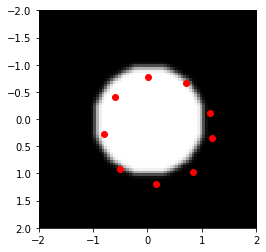

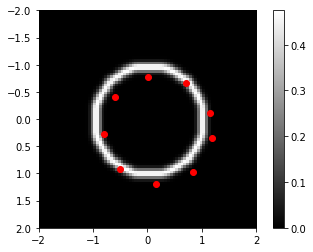

In [11]:
plt.figure()
plt.imshow(I, cmap='gray', extent=[-W, W, W, -W])
plt.scatter(C[:,0]+p[0], C[:,1]+p[1], color='r')
plt.show()

plt.figure()
plt.imshow(E, cmap='gray', extent=[-W, W, W, -W])
plt.colorbar()
plt.scatter(C[:,0]+p[0], C[:,1]+p[1], color='r')
plt.show()

In [12]:
class Interpolant(object):
    def __init__(self, image, origin, spacing, outside_value=0):
        self.image   = image
        self.extent  = image.shape
        self.origin  = origin
        self.spacing = spacing
        self.outside_value = outside_value
        
    def __call__(self, x):
        p     = x-self.origin

        coord = p/self.spacing
        coord = np.array([coord[1], coord[0]])

        index = coord.astype(int)

        i1    = index[0]
        i2    = i1+1
        j1    = index[1]
        j2    = j1+1
        
        if i2 > self.extent[0]-1 or j2 > self.extent[1]-1:
            return self.outside_value
        
        v1    = self.image[i1,j1]
        v2    = self.image[i1,j2]
        v3    = self.image[i2,j2]
        v4    = self.image[i2,j1]

        f1 = (j2-coord[1])*v1 + (coord[1]-j1)*v2
        f2 = (j2-coord[1])*v4 + (coord[1]-j1)*v3
        
        f  = (i2-coord[0])*f1 + (coord[0]-i1)*f2

        return f

In [13]:
interp = Interpolant(E, np.array([-W,-W]), S)

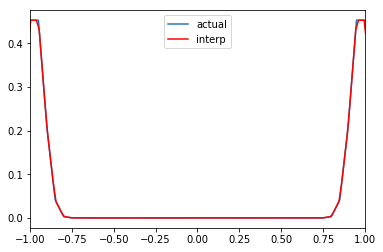

In [14]:
x1 = np.linspace(-W,W-S,H)
x2 = np.linspace(-W,W,3*H)

y1 = E[int(H/2),:]
y2 = [ interp( np.array([x,0]) ) for x in x2 ]
y2 = np.array(y2)
plt.figure()
plt.plot(x1,y1,label='actual')
plt.plot(x2,y2,label='interp',color='r')
plt.legend()
plt.xlim([-1,1])
plt.show()

In [15]:
Nsteps = 5
alpha  = 0.35

def edge_fit(E, C, angles, alpha, R, Nsteps):
    na     = len(angles)
    Cnew   = np.zeros((na,2))
    
    coeffs = np.linspace(-alpha*R,alpha*R,2*Nsteps)
    
    for i,a in enumerate(angles):
        d = np.array([np.cos(a), np.sin(a)])
        
        c = C[i]
    
        v = d[np.newaxis,:]*coeffs[:,np.newaxis]

        z = v+c[np.newaxis,:]

        e = np.array([E(x) for x in z])

        k = np.argmax(e)

        Cnew[i,:] = z[k]
        
    return Cnew.copy()

In [16]:
z = edge_fit(interp, C+p, angles, alpha, R, Nsteps)

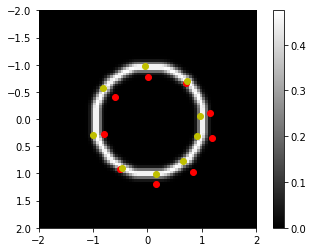

In [17]:
plt.figure()
plt.imshow(E, cmap='gray', extent=[-W, W, W, -W])
plt.colorbar()
plt.scatter(C[:,0]+p[0], C[:,1]+p[1], color='r')
plt.scatter(z[:,0], z[:,1], color='y')
plt.show()